In [1]:
import sqlite3
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
def make_query(query, filepath='database.sqlite'):
    """
    Execute a query on a SQLite database file and return the results as a pandas DataFrame.

    Parameters
    ----------
    query : str
        SQL query to be executed on the database file.
    filepath : str, optional
        Path to the database file, by default 'database.sqlite'.

    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the results of the executed query.
    """
    with sqlite3.connect(filepath) as connection:
        cursor = connection.cursor()
        execution = cursor.execute(query)
        result = pd.DataFrame(execution.fetchall(), columns=[i[0] for i in execution.description])
        return result

# 1. Bepaal met SQL

## Aantal wedstrijden per seizoen

In [3]:
def games_per_season(club='Manchester United', season='2008/2009', all_seasons=True): 
    """
    This function takes in three parameters to return the number of games played by a football club in a specific season or all seasons.

    Parameters
    ----------
        club : str, optional 
            Name of the football club to query. Default value is 'Manchester United'.
        season : str, optional
            Name of the season to query in the format 'YYYY/YYYY'. Default value is '2008/2009'.
        all_seasons : bool, optional
            Boolean value to determine if the query should be for all seasons or just the specific season. Default value is True.

    Returns
    -------
        pandas.core.frame.DataFrame
            If all_seasons is True, returns a Pandas DataFrame containing the seasons and the total number of games played by the club. 
        int 
            If all_seasons is False, returns the total number of games played by the club in the specific season as an integer.
    """
    if all_seasons:
        return make_query(
        f"""

        SELECT  season, COUNT(*) / COUNT(DISTINCT home_team_api_id) * 2 AS games
        FROM Match
        INNER JOIN Team 
        ON Match.home_team_api_id = Team.team_api_id
        WHERE team_long_name LIKE '%{club}%'
        GROUP BY season

        """
        )
    else:
        return make_query(
        f"""

        SELECT  season, COUNT(*) / COUNT(DISTINCT home_team_api_id) * 2 AS games
        FROM Match
        INNER JOIN Team 
        ON Match.home_team_api_id = Team.team_api_id
        WHERE team_long_name LIKE '%{club}%' AND season = '{season}'
        
        """)['games'][0]

### Toelichting games_per_season

Maakt een dataframe van alle seizoenen van een specifieke club en het aantal wedstrijden. Er is ook een mogelijkheid om slecht voor 1 seizoen het aantal wedstrijden te krijgen. We gebruiken deze voor het bepalen van het aantal punten per wedstrijd later in dit notebook.

In [4]:
games_per_season('Manchester United')

,season,games
0,2008/2009,38
1,2009/2010,38
2,2010/2011,38
3,2011/2012,38
4,2012/2013,38
5,2013/2014,38
6,2014/2015,38
7,2015/2016,38


## Aantal wedstrijden in het kalenderjaar 2010

In [5]:
match_data_2010 = make_query(
"""
SELECT season, COUNT(date) AS 'Aantal wedstrijden in  2010'

FROM Match
INNER JOIN Team AS Home_team
    ON Match.home_team_api_id = Home_team.team_api_id
INNER JOIN Team AS Away_team
    ON Match.away_team_api_id = Away_team.team_api_id
INNER JOIN League AS League_name
    ON Match.league_id = League_name.id

WHERE (home_team_api_id = '10260' OR away_team_api_id = '10260')
AND (date LIKE '2010%')

GROUP BY season
ORDER BY date

""")

### Toelichting match_data_2010

Het aantal wedstrijden dat in 2010 zijn gespeeld en dus niet in andere jaren. Deze wedstrijden zitten dus in het seizoen 2009/2010 en het seizoen 2010/2011.

In [6]:
match_data_2010

,season,Aantal wedstrijden in 2010
0,2009/2010,18
1,2010/2011,18


## Punten iedere club in gekozen competitie per seizoen.

In [7]:
def club_points_seasons(league='Premier'):
    """ 
    Generates a DataFrame containing the total points earned by each club in each season of a given league.
    
    Parameters
    ----------
        league : str, optional 
            The league for which to generate the points table. Defaults to 'Premier'.
        
    Returns
    -------
        pandas.core.frame.DataFrame
            The dataframe containing the total points earned by each club in each season of the specified season.
    """    
    container = make_query(
    f"""

    SELECT DISTINCT(season), name
    FROM Match
        INNER JOIN League
            ON Match.league_id = League.id
        WHERE League.name IN (SELECT name
                              FROM League
                              WHERE name LIKE '%{league}%'
                              LIMIT 1)
    """)
    league, season = container['name'][0], list(container['season'])
    for i in range(len(season)):
        current = make_query(
        f"""

        SELECT team_long_name AS Club, SUM(wins) AS '{season[i]}'
        FROM (SELECT CASE WHEN home_team_goal > away_team_goal THEN home_team_api_id 
                          WHEN home_team_goal < away_team_goal THEN away_team_api_id END AS winners,
                     (COUNT(*) * 3) AS wins

              FROM Match
                  INNER JOIN League
                      ON league_id = League.id
                  WHERE League.name LIKE '{league}' AND season='{season[i]}'

              GROUP BY winners

              UNION

              SELECT home_draw AS Team, SUM(draws) AS Draws
              FROM (SELECT CASE WHEN home_team_goal = away_team_goal THEN home_team_api_id END AS home_draw,
                           COUNT(*) AS draws

                    FROM Match
                        INNER JOIN League
                            ON league_id = League.id
                        WHERE League.name LIKE '{league}' AND season='{season[i]}'

                    GROUP BY home_draw

                    UNION

                    SELECT CASE WHEN home_team_goal = away_team_goal THEN away_team_api_id END AS away_draw,
                           COUNT(*)

                    FROM Match
                        INNER JOIN League
                            ON league_id = League.id
                        WHERE League.name LIKE '{league}' AND season='{season[i]}'

                    GROUP BY away_draw
                   )
              GROUP BY home_draw
              )
        INNER JOIN Team
            ON winners = Team.team_api_id

        GROUP BY winners
        
        """
        )
        if i == 0:
            df = current
        else:
            df = df.merge(right=current, on='Club', how='outer')
            df.fillna(0, inplace=True)
    df.iloc[:, 1:] = df.iloc[:, 1:].astype(int)
    return df

### Toelichting club_season_points

Maakt een dataframe van alle clubs in een league en de resultaten per seizoenen.
Ook teams staan erin die niet alle seizoenen hebben meegedaan. Deze clubs zijn bijv. gedegradeerd. Desondanks willen we ook deze informatie hebben voor de volgende opdrachten. Voor alle clubs die niet hebben meegedaan in een bepaald seizoen worden ze aangeduidt met 0 punten. Dit ranglijst is in volgorde op totaal aantal punten gerangschikt. Manchester United is daarmee eerste geworden.

In [35]:
test = club_points_seasons()
data = test.sum(axis = 1)
test['total'] = data
ranking = test.sort_values(by=['total'], ascending=False)
ranking


C:\Users\nimaa\AppData\Local\Temp\ipykernel_7688\1795001533.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = test.sum(axis = 1)


,Club,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016,total
18,Manchester United,90,85,80,89,89,64,70,66,633
0,Chelsea,83,86,71,64,75,82,87,50,598
1,Manchester City,50,67,67,89,78,86,79,66,582
14,Arsenal,72,75,68,70,68,79,75,71,578
8,Liverpool,86,63,58,52,61,84,62,60,526
7,Tottenham Hotspur,51,70,62,69,72,66,64,70,524
13,Everton,57,61,54,56,63,72,47,47,457
16,Stoke City,45,47,46,45,42,50,54,51,380
17,Aston Villa,62,64,48,38,41,38,38,17,346
3,Sunderland,36,44,47,45,39,38,38,33,320


## Positie van gekozen club die is geëindigd op de ranglijst

In [9]:
def rank(club='Manchester United', season='2008/2009'):
    """
    Retrieves the rank of a specific club in a specific season. 

    Parameters
    ----------
        club : str, optional
            The name of the club whose rank is to be retrieved. Defaults to 'Manchester United'.
        season : str, optional
            The season for which the rank is to be retrieved, in the format 'YYYY/YYYY'. Defaults to '2008/2009'.

    Returns
    -------
        int
            The rank of the club in the season.
    """
    league, club = make_query(
    f"""

    SELECT league.name, team_long_name 

    FROM League
        INNER JOIN Match
    ON League.id = league_id
        INNER JOIN Team
    ON Match.home_team_api_id = Team.team_api_id

    WHERE team_long_name LIKE '%{club}%'
    
    LIMIT 1
    
    """).iloc[0, :]
    
    container = club_points_seasons(league)[['Club',season]].sort_values(by=season, ascending=False)
    for i in range(len(container)):
        if club == container.iloc[i, :][0]:
            return i + 1


### Toelichting club_season_points

Laat zien het resultaat zien van een seizoen van een club. Manchester United is bijvoorbeeld 1e geworden in 2008/2009. 

In [34]:
rank('Manchester United', '2008/2019')

2

# 2. Hebben teameigenschappen invloed op aantal punten?

## Dataframe punten per club samengevoegd met dataframe teameigenschappen.

In [11]:
league_names = list(make_query("""SELECT name FROM League""")['name'])
all_leagues = []

for x in league_names:
    current_league = club_points_seasons(x)
    all_leagues.append(current_league.melt(id_vars='Club', var_name='Season', value_name='Points').sort_values(by=['Club', 'Season']).reset_index(drop=True))

all_leagues = pd.concat(all_leagues)
all_leagues = all_leagues[all_leagues['Points'] > 0]

### Toelichting all_leagues

all_leagues zijn alle resultaten van alle clubs over alle seizoenen. We hebben op deze manier dus veel meer data t.o.v. als we het bijvoorbeeld alleen naar de Premier league zouden kijken. Op deze manier kunnen we ook dus beter zien of de teameigenschappen wel correlatie hebben met het aantal punten.

In [12]:
all_leagues

,Club,Season,Points
0,Beerschot AC,2008/2009,42
1,Beerschot AC,2009/2010,31
2,Beerschot AC,2010/2011,26
3,Beerschot AC,2011/2012,36
4,Beerschot AC,2012/2013,23
...,...,...,...
105,Neuchâtel Xamax,2009/2010,37
106,Neuchâtel Xamax,2010/2011,32
107,Neuchâtel Xamax,2011/2012,26
115,Servette FC,2011/2012,45


In [13]:
def team_attributes(isEvaluation=False):
    if isEvaluation:
        season = """CASE WHEN strftime('%m', Team_attributes.date) > '08' THEN strftime('%Y', Team_attributes.date, '-1 year') || '/' ||strftime('%Y', Team_attributes.date) 
                    ELSE strftime('%Y', Team_attributes.date, '-2 year') || '/' || strftime('%Y', Team_attributes.date, '-1 year') END AS Season,"""
    else:
        season = """CASE WHEN strftime('%m', Team_attributes.date) > '08' THEN strftime('%Y', Team_attributes.date) || '/' ||strftime('%Y', Team_attributes.date, '+1 year') 
                    ELSE strftime('%Y', Team_attributes.date, '-1 year') || '/' || strftime('%Y', Team_attributes.date) END AS Season,"""
    attributes = make_query(
        f"""
        SELECT Team.team_long_name AS Club,
               {season}
               buildUpPlaySpeed,
               buildUpPlayDribblingClass,
               buildUpPlayPassing,
               buildUpPlayPositioningClass,
               chanceCreationPassing,
               chanceCreationCrossing,
               chanceCreationShooting,
               chanceCreationPositioningClass,
               defencePressure,
               defenceAggression,
               defenceTeamWidth,
               defenceDefenderLineClass
        FROM Team_attributes

        INNER JOIN Team
            USING (team_api_id)

        ORDER BY Club, Season
        """
        )

    l = ['buildUpPlayPositioningClass', 'chanceCreationPositioningClass', 'defenceDefenderLineClass']

    for x in l:
        current = pd.get_dummies(attributes[x], prefix=x[:-5], prefix_sep='', drop_first=True)
        attributes.drop(x, axis=1, inplace=True)
        attributes[current.columns[0].replace(' ', '')] = current

    attributes['buildUpPlayDribblingClass'] = attributes['buildUpPlayDribblingClass'].map({'Little': 1, 'Normal': 2, 'Lots': 3})
    return attributes

### Toelichting Team attributes, en onzekerheid

De gegevens in "Team attributes" komen uit het FIFA-voetbalspel. We weten niet zeker of deze gegevens enigzins iets betekenen en ze zijn niet beschikbaar voor elk seizoen. Er is geen kolom die aangeeft welk seizoen de informatie betreft, maar we hebben het seizoen bepaald op basis van de datum. <br>
We weten echter niet wat de datum precies aangeeft. Het kan een evaluatie zijn hoe het team dat jaar gespeeld heeft, maar ook een voorspelling voor het volgende seizoen. We hebben beide situaties bekeken en zagen nauwlijks verschillen dus gaan we verder met isEvaluation=False. <br>

In [14]:
attributes = team_attributes()
all_leagues = pd.merge(left=all_leagues, right=attributes, on=['Club', 'Season'])

all_leagues_iterable = all_leagues.index
points_per_game = []

for i in all_leagues_iterable:
    try:
        points_per_game.append(all_leagues['Points'][i] / (games_per_season(all_leagues['Club'][i], all_leagues['Season'][i], all_seasons=False))) 
    except:
        points_per_game.append(None)

all_leagues['Points_per_game'] = points_per_game
all_leagues = all_leagues[all_leagues['Points_per_game'].isna() == False]

### Toelichting dataframes samenvoegen en points_per_game

In de cel hierboven mergen we de dataframes en tot slot gaan we nog de punten per wedstrijd berekenen. We hebben dit nodig aangzien sommige competities meer/minder wedstrijden hebben dan andere competities. Het aantal punten kunnen we op die manier beter bekijken omdat ze geproportioneerd zijn per wedstrijden i.p.v. per seizoen.

Deze functie is trouwens heel erg traag omdat het per club nog moet bekijken hoeveel wedstrijden er in dat specifieke seizoen zijn gespeeld.

In [15]:
all_leagues

,Club,Season,Points,buildUpPlaySpeed,buildUpPlayDribblingClass,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,buildUpPlayPositioningOrganised,chanceCreationPositioningOrganised,defenceDefenderLineOffsideTrap,Points_per_game
0,Beerschot AC,2009/2010,31,35,1,35,45,40,50,70,70,70,1,1,0,1.107143
1,Beerschot AC,2010/2011,26,47,1,37,54,64,67,33,34,48,1,1,1,0.866667
2,Beerschot AC,2011/2012,36,55,1,55,47,46,49,45,46,50,1,1,0,1.200000
3,Club Brugge KV,2009/2010,54,35,1,40,45,50,45,60,70,70,1,1,0,1.928571
4,Club Brugge KV,2010/2011,53,67,1,47,68,49,53,57,44,47,0,0,0,1.766667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,Grasshopper Club Zürich,2015/2016,53,50,2,54,52,54,46,36,43,47,1,1,0,1.472222
1087,Neuchâtel Xamax,2009/2010,37,60,1,45,60,70,60,50,45,55,1,1,0,1.027778
1088,Neuchâtel Xamax,2010/2011,32,54,1,47,37,48,53,49,45,52,1,1,0,0.888889
1089,Neuchâtel Xamax,2011/2012,26,49,1,50,39,48,34,34,31,51,1,1,0,1.444444


## Aantal punten en hun correlatie met teamkenmerken

Voordat we de correlatie gaan berekenen zullen we eerst moeten bekijken welke correlatie methode we gaan gebruiken.
Hieronder staan alle methoden met alle voorwaarden voor een populatie.

- **Pearson-correlatiecoefficient**
    1. weinig uitschieters
    2. normale verdeling
    3. lineaire relatie
    4. Homoscedasticiteit (we weten niet precies wat dit is)

- **Spearman-correlatiecoefficient**
    1. weinig uitschieters
    2. geen nominale gegevens.
    3. monotone relatie (als de ene variabele toeneemt/afneemt dan moet de andere ook toenemen/afnemen)

- **Kendalls Tau**
    1. weinig uitschieters
    2. geen nominale gegevens.
    3. monotone relatie (als de ene variabele toeneemt/afneemt dan moet de andere ook toenemen/afnemen)
    
Voor alle methoden geldt dat de voorwaarde "weinig uitschieters" voldaan moet worden hier beginnen we dus mee.

## 1. Weghalen van uitschieters

In [16]:
def exclude_outliers(dataframe):
    """
    Excludes outlier values from a DataFrame using the 1.5 * IQR rule.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The input DataFrame from which outliers should be removed.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with outliers excluded from each column.
    """
    columns = dataframe.columns
    
    for column in columns:
        try:
            q1 = np.percentile(dataframe[column], 25)
            q3 = np.percentile(dataframe[column], 75)

            lower_bound = q1 - (1.5 * (q3-q1))
            upper_bound = q3 + (1.5 * (q3-q1))

            dataframe = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]
        except:
            pass
    
    dataframe.reset_index(inplace=True, drop=True)
    return dataframe

### Toelichting remove_outliers

We hebben een functie gemaakt die van elke dataframe de uitschieters kan verwijderen.
Hieronder gaan we alle outliers voor iedere kolom eruithalen. We hebben dan i.i.g. de 1e voorwaarde voor alle methoden voldaan. hieronder hebben we nog wat boxplots zodat we goed kunnen kijken of het gelukt is.

In [17]:
correlation_data = exclude_outliers(all_leagues)

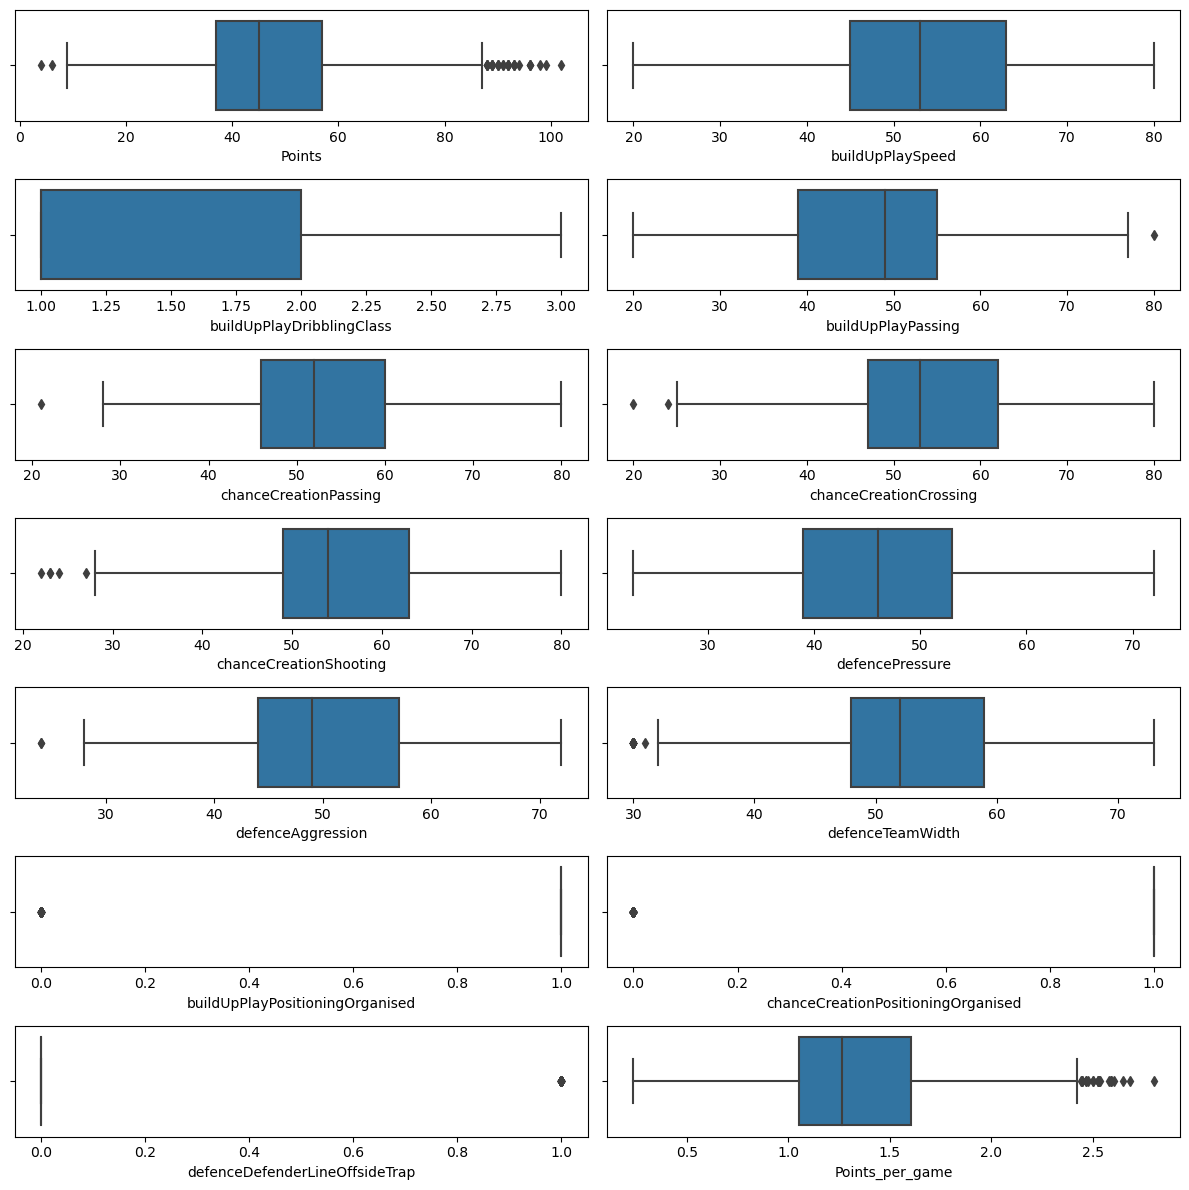

In [18]:
all_leagues_columns = all_leagues.columns[2:]
correlation_columns = correlation_data.columns[2:]

fig, axis = plt.subplots(ncols=2, nrows=7, figsize=(12, 12), dpi=100)

for i in range(len(all_leagues_columns)):
    sns.boxplot(data=all_leagues, x=all_leagues_columns[i], ax=axis[i//2][i%2])
      
plt.tight_layout()

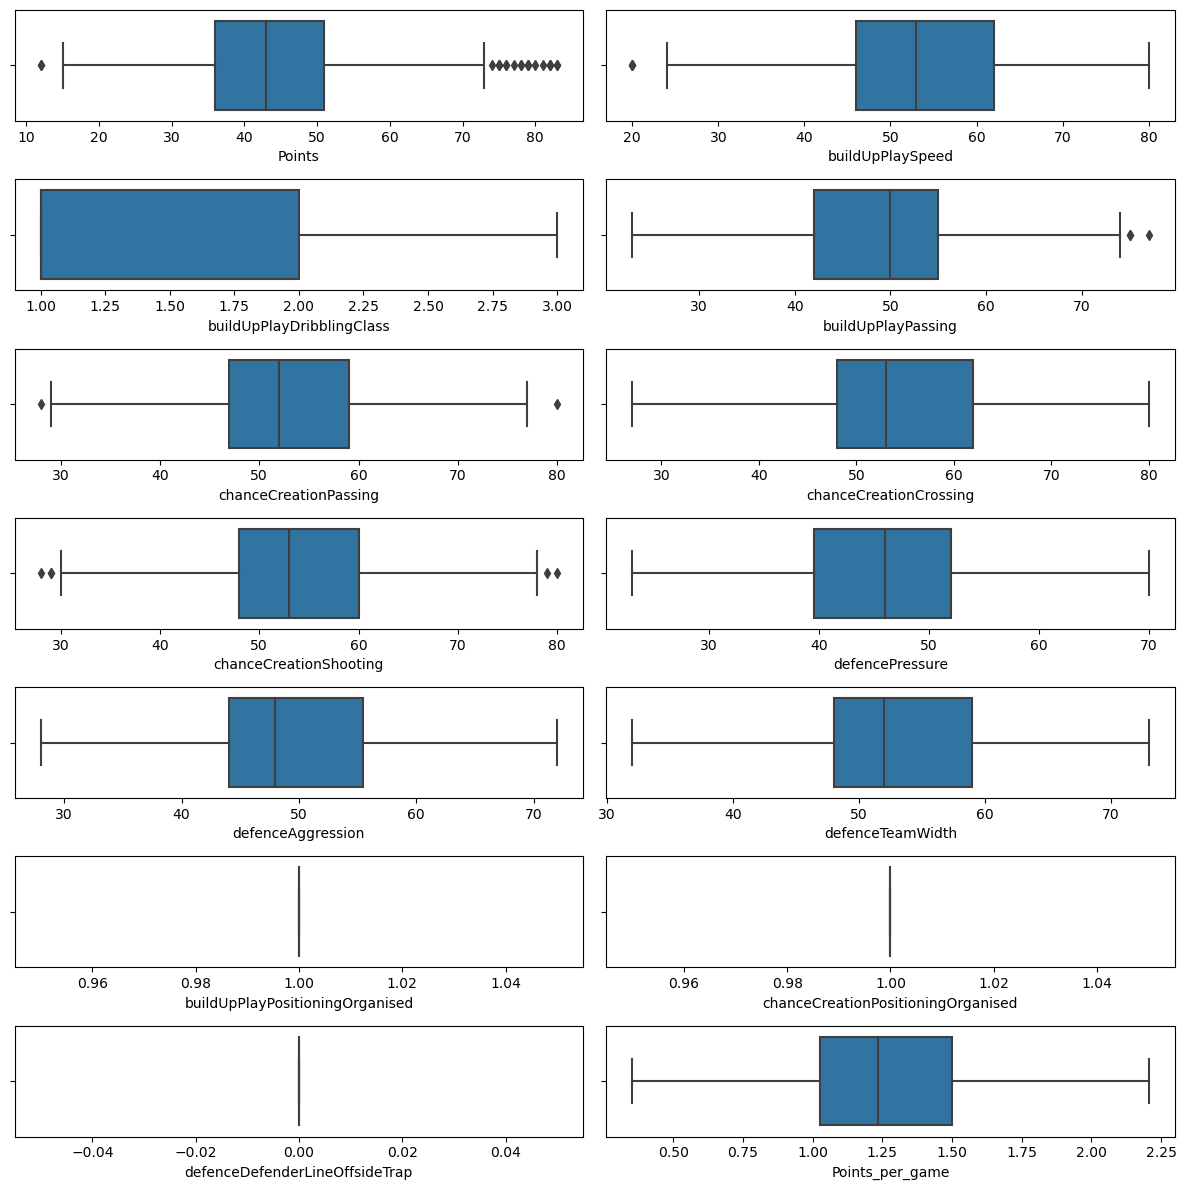

In [19]:
fig, axis = plt.subplots(ncols=2, nrows=7, figsize=(12, 12), dpi=100)

for i in range(len(all_leagues_columns)):
    sns.boxplot(data=correlation_data, x=all_leagues_columns[i], ax=axis[i//2][i%2])
      
plt.tight_layout()

### Toelichting boxplots

Het was voor ons eerst verassend dat er in de nieuwe boxplots nog steeds uitschieters zaten. Hoe dit komt weten we niet precies. Wat wel zo is is natuurlijk dat door het verwijderen van outliers de verdeling verandert. Het kan dan natuurlijk zijn dat er met de nieuwe gedefineerde onder en bovengrens er weer nieuwe uitschieters zijn. Echter zijn er vooral bij de eerste boxplot veel uitschieters. Als we dan domeinkennis inzetten is het natuurlijk zo dat in sommige competities echt wel momenten zijn dat een team boven de 80 punten kan hebben. We zien bijvoorbeeld bij de laatste boxplot dat dit dan weer niet het geval is. Dus het is waarschijnlijk verstandig om eerder met "Points_per_game" te werken dan met "Points".



## 2. Normale verdeling?

We gaan nu bekijken of de variabelen een normale verdeling hebben. Als we zien dat er geen normale verdeling is weten we dat we het Spearman-correlatiecoefficient of Kendall's Tau moeten gebruiken.

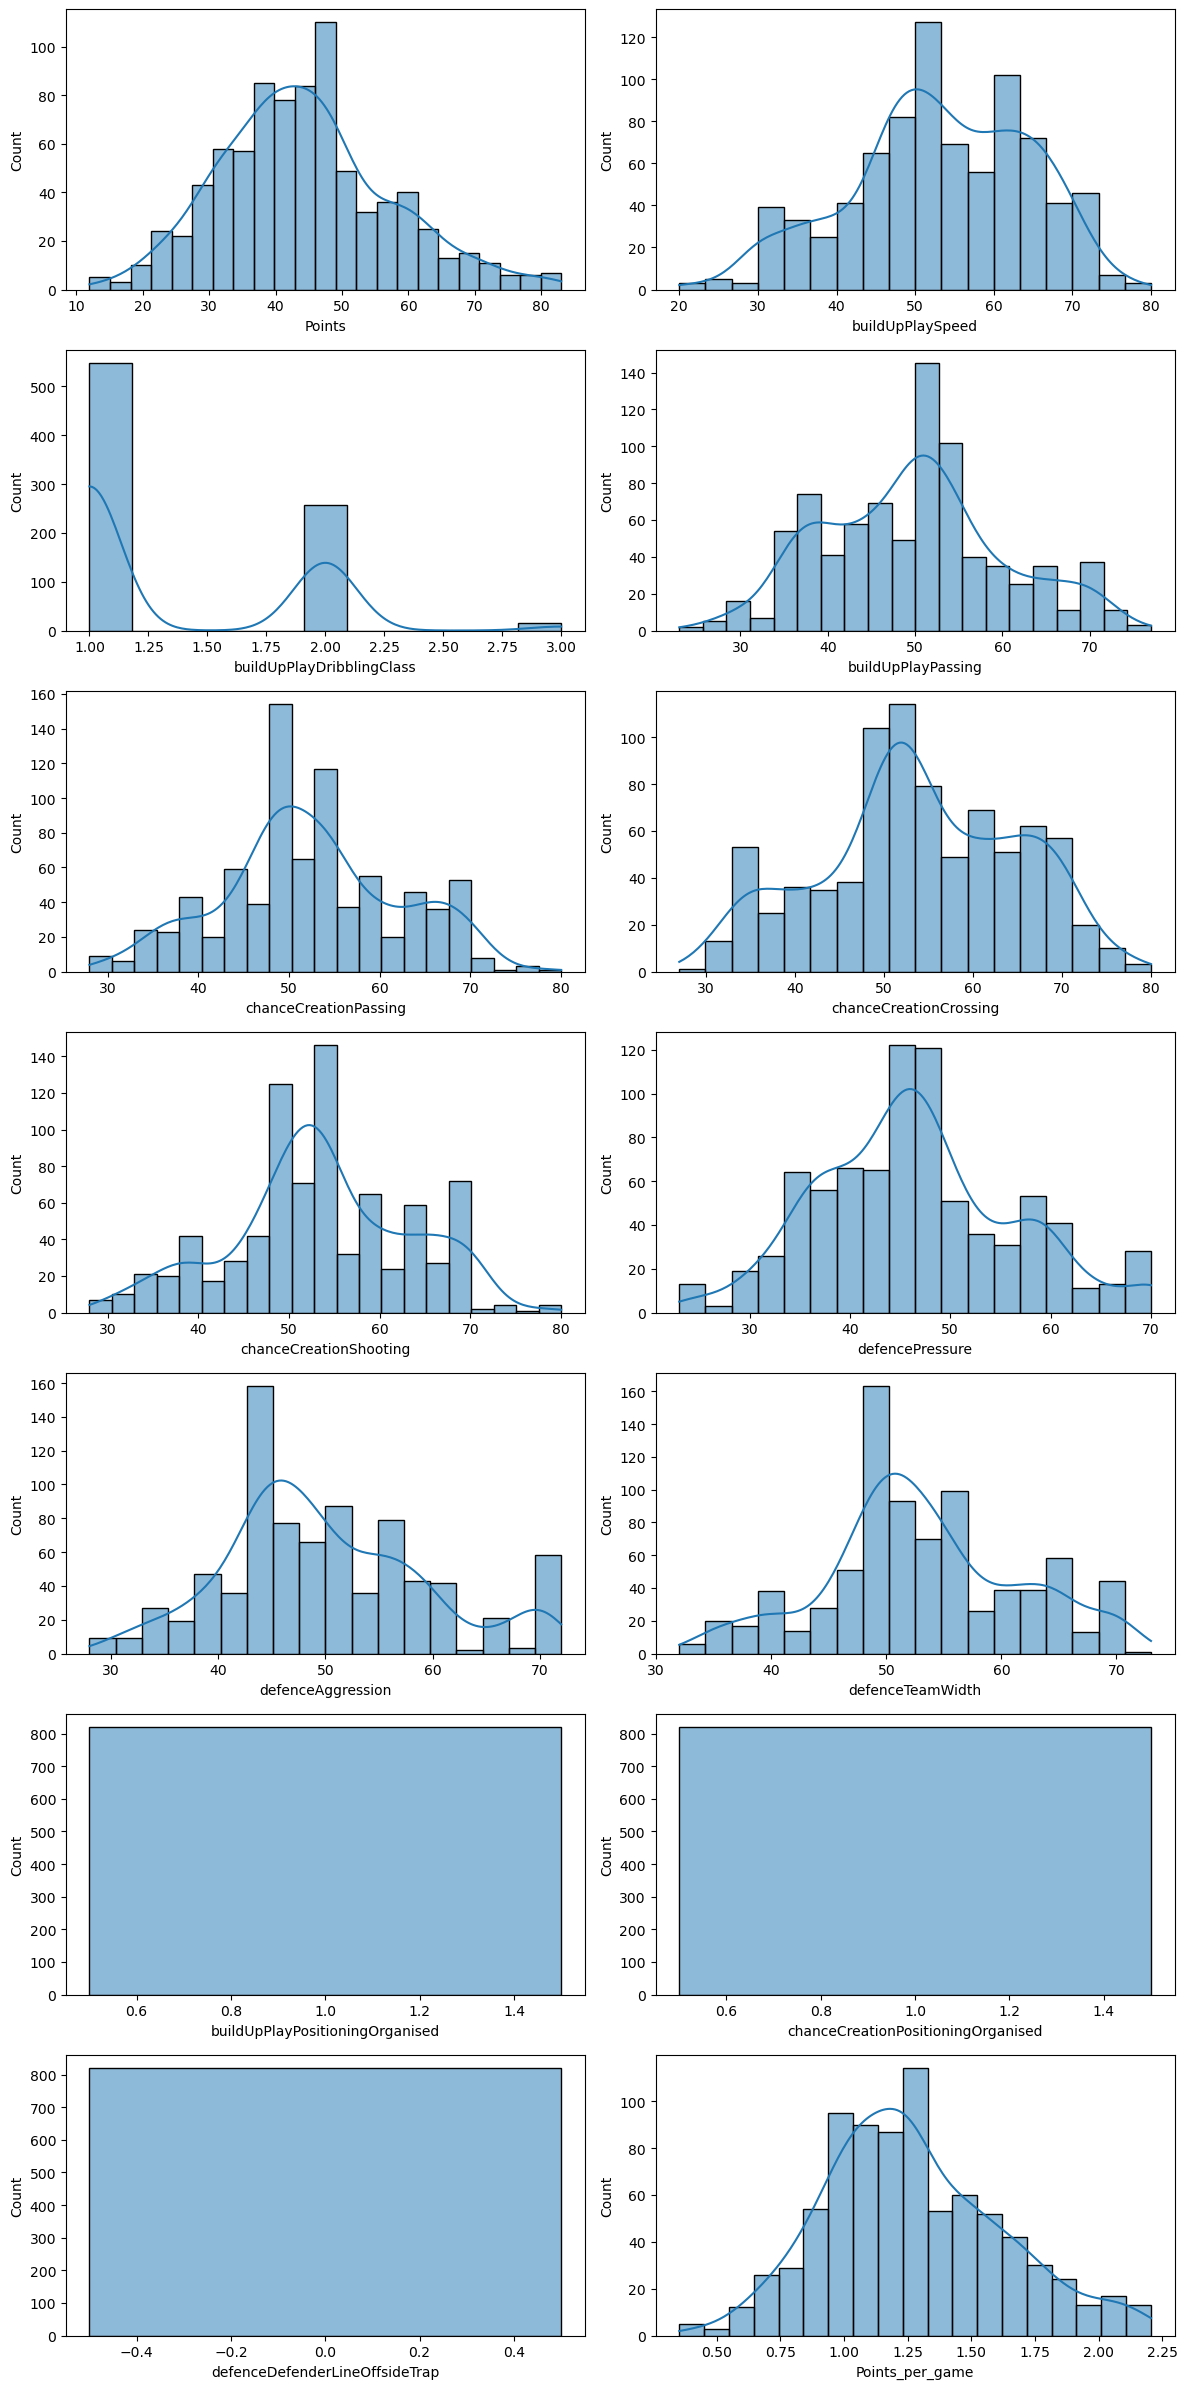

In [20]:
fig, axis = plt.subplots(ncols=2, nrows=7, figsize=(12, 24), dpi=100)

for i in range(len(correlation_columns)):
    sns.histplot(data=correlation_data, x=correlation_columns[i], ax=axis[i//2][i%2], kde=True)
    
plt.tight_layout()

### Toelichting normaalverdelingen

We zien dat "Points" en "Points_per_game" alleen echt normaal verdeeld lijken. Dit komt niet goed uit want eigenlijk zijn de teameigenschappen het belangrijkste om te bekijken. Het lijkt erop dat Pearson-correlatiecoefficient geen goed manier zal zijn om correlatie te bekijken. We gaan tot slot nog de Shapiro-Wilk statistische toets doen.

In [21]:
for i in range(len(correlation_columns)):
    print(f'{correlation_columns[i]} p_value:\n\t{stats.shapiro(correlation_data[correlation_columns[i]])[1]}')
    

Points p_value:
	2.760532140655414e-07
buildUpPlaySpeed p_value:
	1.4485552313203698e-08
buildUpPlayDribblingClass p_value:
	1.237993103110253e-38
buildUpPlayPassing p_value:
	1.6185474294161395e-07
chanceCreationPassing p_value:
	1.7936280016783712e-07
chanceCreationCrossing p_value:
	3.288171956938868e-09
chanceCreationShooting p_value:
	1.878638755670181e-08
defencePressure p_value:
	1.685471318069176e-08
defenceAggression p_value:
	9.997805534844861e-13
defenceTeamWidth p_value:
	5.729177687818776e-10
buildUpPlayPositioningOrganised p_value:
	1.0
chanceCreationPositioningOrganised p_value:
	1.0
defenceDefenderLineOffsideTrap p_value:
	1.0
Points_per_game p_value:
	1.1022469692534287e-07


C:\Users\nimaa\anaconda3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


### Toelichting Shapiro-Wilk toets

De Shapiro-Wilk toets wordt gebruikt om te kijken of een variabele normaal verdeeld is. 
Voor de Shapiro-Wilk-toets geldt:

- p_value >= 0.05 -> gegevens normaal verdeeld.
- p_value < 0.05 -> gegevens niet normaal verdeeld.

Geen enkele variabele is dus normaal verdeeld zelfs niet de 2 boxplots waarvan we dat enigszins van verwachtte. Dit betekent dus dat we het Pearson-correlatiecoefficient niet kunnen gebruiken.

## 3. Spearman en Kendall's Tau

Aangezien we nu weten dat we niet Pearson kunnen gebruiken als correlatiecoefficient gaan we de methodes spearman en kendall's tau bekijken. De voorwaarden die voldaan moeten worden zijn hetzelfde. We hebben aan de voorwaarde van weinig uitschieters voldaan. De voorwaarde dat er geen nominale gegevens mogen zijn hebben we ook voldaan. De monotone relatie kunnen we zelf eigenlijk al aantonen als we het correlatiecoefficient bekijken. We kunnen dus beide methodes bekijken.

<AxesSubplot:>

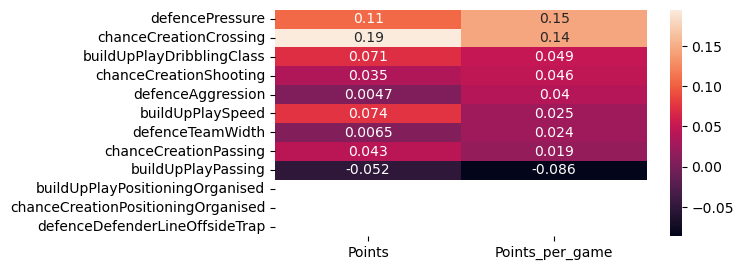

In [22]:
fig, ax = plt.subplots(figsize=(6,3), dpi=100)

sns.heatmap(correlation_data.corr(method='spearman')[['Points', 'Points_per_game']].drop(['Points', 'Points_per_game']).sort_values(by='Points_per_game', ascending=False), annot=True)

<AxesSubplot:>

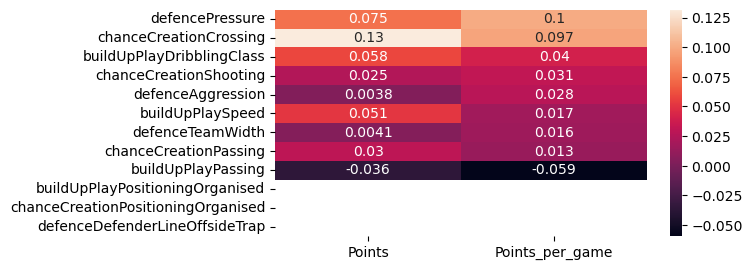

In [23]:
fig, ax = plt.subplots(figsize=(6,3), dpi=100)

sns.heatmap(correlation_data.corr(method='kendall')[['Points', 'Points_per_game']].drop(['Points', 'Points_per_game']).sort_values(by='Points_per_game', ascending=False), annot=True)

### Toelichting correlaties 

Hier zien we alle teamkenmerken en hun correlatie aan het "aantal punten" en "punten per wedstrijd". Het laat niet echt enige correlatie zien. Het liefst zou je een aantal variabelen willen zien die absolute waarden hebben van boven de 0.5. Zelfs van matige correlatie is geen sprake.(waarden van 0.3 - 0.5) Er is dus tot nu toe niet echt een verband te vinden tussen het aantal punten of punten per wedstrijd met deze variabelen. Wij hebben het i.i.g. niet gevonden.